# Week 2 - NLP and Deep Learning

---

# Lecture 3. Command line and experimental setup

## 1. Linux Command Line for NLP: Conll Format
In natural language processing, the "conll" format has become a standard way to represent annotated text. There is a variety of conll formats, so it might be more correct to refer to them as conll-like formats. These formats have one word per line, separate sentences with an empty line, and have separate collumns (separated with tabs) for each annotation layer.

In this assignment, we will use the conll format for named entity recognition (from conll2002: [paper](https://aclanthology.org/W02-2024.pdf)). We will use Danish data from (DaN+)[https://aclanthology.org/2020.coling-main.583.pdf]. This data follows the BIO labels as discussed in the lecture. An example of the data is shown below, this example has one entity-span "goergh bush":

```
-       O
en      O
mand    O
der     O
hedder  O
goergh  B-PER
bush    I-PER
.       O

```


Use Unix command line tools for this assignment (grep, sed, etc.)

* a) Search in the `da_arto.conll` file (in the week2 directory) for first names. You can assume that first names always have the label B-PER, and that the string "B-PER" does not occur in the first column. 
* b) How many names occur in the data?
* c) How can we make sure that we do not match the string "B-PER" occuring in the first column?
* d) How can we clean away the labels, so that we have only a list of names left? (hint: pipe the result of the previous command into a `split`) (use cut)
* e) How many of the names you found start with an uppercased character?

Note: you can use an exclamation mark in jupyter notebooks to run bash commands instead of python code:


In [14]:
!cd C:\Users\elias\Desktop\_ITU\4. semester\NLP\Github\NLP_25\week1\week2
!grep B-PER da_arto.conll

#does not work on windows

The system cannot find the path specified.
'grep' is not recognized as an internal or external command,
operable program or batch file.


## 2. More Advanced Usage of Unix Tools: Creating a word frequency list, finding function words
Let us now create a simple word frequency list from a *The Adventures of Sherlock Holmes* by Arthur Conan Doyle (pg1661.txt). Which (function) words are the most frequent in this text?

a) Tokenize the text, for simplicity, you can just assume a whitespace separation tokenizer. The result should be one word per line. You can use `sed` or `tr`.

b) Sort the results with `sort`.

c) Now use `uniq` to count the words.

d) Finally, sort the list with `sort` in reverse numerical order, and inspect the top of the results (with `head` or `less`). How many (approximately) of the top words are function words?

Hint: find the options to the commands with `man` (e.g. `man sort`).

In [15]:
#done in wsl
#cat token1661.txt |sort |uniq -c | sort -r |head

## 3. Annotation 

Find the file with your ITU username in `assignments/week2/pos-data/`. In this file, you will find 20
sentences which are pre-tokenized and in conll format. Behind each word you are supposed to annotate the pos tag, with one tab in between. The final file should look like this:

```
Seriously	ADV
:	PUNCT
do	AUX
not	PART
waste	VERB
your	PRON
time	NOUN
.	PUNCT

```

You should use a tab between the word and its tag. Please check with the script posCheck.py
whether the file format is correct. Usage: `python3 check-pos.py origFile annotatedFile`
For annotation guidelines we refer to the slides and https://universaldependencies.org/u/pos/all.html. Alternatively, it might be helpful to look at example annotations, which are provided in:
`assignments/week2/pos-data/ewt.train.txt`

### Annotation tool
If you prefer to work with an annotation tool instead of text files directly, you can use an annotation tool. You have to make sure to upload the data to LearnIt in the format described above though. I would recommend [Eevee](https://axelsorensen.github.io/EeveeTest/) because it is easy to set up and it works natively with this data format. An Eevee configuration file is available in the repo (`assignments/week2/eevee_pos.json`), and an explanation on how to use it is available from the [repo](https://github.com/AxelSorensenDev/Eevee). In short, you would have to import the configuration file with the ``Import task button``, and then import the POS data with the ``Import "conll-like" file`` button, then you can click ``Annotate`` and get started. The tool works completely in your browser, so make sure to download a backup of your data at a regular interval. Also, it has been made in collaboration with Rob, and any feedback is more than welcome. 

## 4. Annotation Quality
After you have finished assignment 3, you can contact a TA to obtain data from another annotator. The data will also be made available on LearnIt at 13:30, but we **STRONGLY** recommend to not look at the data from the annotator before completing your annotation.

* a) Calculate the accuracy between you and the other annotator, how often did you agree?
* b) Now implement Cohen’s Kappa score, and calculate the Kappa for your annotation sample. In which range
does your Kappa score fall?
* c) Take a closer look at the cases where you disagreed with the other annotator; are these disagreements due
to ambiguity, or are there mistakes in the annotation? Would you classify your agreement in the same category as it falls in the standard kappa interpretation?

# Lecture 4: Generative and Discriminative Classification

## 5. Words as Features
In this assignment, we will convert a text to a matrix of features for the purpose of language identification. We will use data from star-wars fandom wikipedia:
* English [Wookipedia](https://starwars.fandom.com/wiki/Main_Page)  
* Danish [Kraftens Arkiver](https://starwars.fandom.com/da/wiki) 
* Dutch [Yodapedia](https://starwars.fandom.com/da/wiki)

We have already tokenized the data for you. The data can be read like this:

In [16]:
def load_langid(path):
    text = []
    labels = []
    for line in open(path, encoding='utf-8'):
        tok = line.strip().split('\t')
        labels.append(tok[0])
        text.append(tok[1])
    return text, labels

wooki_train_text, wooki_train_labels = load_langid('langid-data/wookipedia_langid.train.tok.txt')
wooki_dev_text, wooki_dev_labels = load_langid('langid-data/wookipedia_langid.dev.tok.txt')

In [17]:
tokens=[]
for i in range(len(wooki_train_text)):
    tokens += wooki_train_text[i].split(" ")

print(len(tokens))
tokens=list(set(tokens))
print(len(tokens))


292118
37816


a) Convert the train data to "binary word features". This means that every instance (sentence) is represented by a vector of binary values, each of which corresponds to a word. For example (features are on the columns, input on the rows):

|             | hello | bye | there | here | ... |
|-------------|-------|-----|-------|------|-----|
| hello there | 1     | 0   | 1     | 0    |     |
| bye bye     | 0     | 1   | 0     | 0    |     |


Note that this means that you will end up with a matrix of size `(#data_instances, len(vocab))` where `vocab` contains your vocabulary (i.e. all the words in the train data), and the `#data_instances` is the number of input sentences (feel free to use numpy, torch or native python lists). This matrix will be filled with 0's and 1's, indicating which features are present in which instances.

**Hint**: Start with two sentences, as it is much easier to debug (and with 1 sentence, you will have only 1s)

b) Convert the dev data to the same features generated from the training data. Note that no new features can be introduced at this point, check whether the size of the matrix is `(#dev_instances, len(vocab))`.

c) What are the pros and cons of representing text as `BOW` (bag-of-words)

In [18]:
BOW_list=[]
for sentence in wooki_train_text:
    sentence_bow=[0]*len(tokens)
    for i in range(len(tokens)):
        if tokens[i] in sentence:
            sentence_bow[i]=1
    BOW_list.append(sentence_bow)

In [19]:
DEV_BOW_list=[]
for sentence in wooki_dev_text:
    sentence_bow=[0]*len(tokens)
    for i in range(len(tokens)):
        if tokens[i] in sentence:
            sentence_bow[i]=1
    DEV_BOW_list.append(sentence_bow)

#C  it's very sparse, lots of 0's to store, and takes a long time to make (if non optimised)

## 6. Character n-grams
Character n-grams can have some advantages over word-level features, as there can be more overlap and less unknown features. It is common to use a range of n-gram sizes, for example 3-6 is a common choice. Convert the following text to character n-grams, use a range of 1-3 (so unigrams, bigrams and trigrams). You do not have to make use of special start characters:

In [20]:
input_data = 'This is a fish'

ngrams = []

expected_output = ['T', 'h', 'i', 's', ' ', 'i', 's', ' ', 'a', ' ', 'f', 'i', 's', 'h', 'Th', 'hi', 'is', 's ', ' i', 'is', 's ', ' a', 'a ', ' f', 'fi', 'is', 'sh', 'Thi', 'his', 'is ', 's i', ' is', 'is ', 's a', ' a ', 'a f', ' fi', 'fis', 'ish']

In [21]:

ngrams = []
for i in range(len(input_data)):
   ngrams.append(input_data[i])

for i in range(len(input_data)):
    if i <len(input_data)-1:
        ngrams.append(input_data[i:i+2])

for i in range(len(input_data)):
    if i <len(input_data)-2:
        ngrams.append(input_data[i:i+3])

ngrams==expected_output

True

In [22]:
input_data[1]

'h'

## 7. Naive Bayes Classifier

Solve the following exercises from [Chapter 4 of Speech and Language processing](https://web.stanford.edu/~jurafsky/slp3/4.pdf), note that you do not have to use python for these:

a) Exercise 4.1 from J&M: (copied here for your convenience):

Assume the following likelihoods for each word being part of a positive or
negative movie review, and equal prior probabilities for each class.

| feature         | pos | neg     |
| :---        |    :----:   |          ---: |
| I      |  0.09      |  0.16  |
| always   | 0.07        | 0.06      |
| like      | 0.29       | 0.06   |
| foreign      | 0.04       | 0.15   |
| films      |  0.08      | 0.11   |

- What class will Naive Bayes assign to the sentence `“I always like foreign films.”`?



In [23]:
good=0.009*0.07*0.29*0.04*0.08
bad=0.16*0.06*0.06*0.15*0.11

print(bad>good)

True


b) Exercise 4.2 from J&M (copied here for your convenience):

Given the following short movie reviews, each labeled with a genre, either comedy or action:

1. fun, couple, love, love **comedy**

2. fast, furious, shoot **action**

3. couple, fly, fast, fun, fun **comedy**

4. furious, shoot, shoot, fun **action**

5. fly, fast, shoot, love **action**

and a new document D:

```
fast, couple, shoot, fly
```

- Compute the most likely class for D. Assume a Naive Bayes classifier and use *add-1 smoothing* for the likelihoods.

In [24]:
comedy = ["fun", "couple", "love", "love", "couple", "fly", "fast", "fun", "fun"]
action = ["fast", "furious", "shoot", "furious", "shoot", "shoot", "fun", "fly", "fast", "shoot", "love"]

comedy_unique=list(set(comedy+action))
action_unique=list(set(comedy+action))

comedy_dict = {item: 0 for item in comedy_unique}
action_dict = {item: 0 for item in comedy_unique}

#comedy
for word in comedy:
     comedy_dict[word]+=1
comedy_dict = {key: value + 1 for key, value in comedy_dict.items()}
com_sum = sum(comedy_dict.values())
comedy_dict = {key: value /com_sum for key, value in comedy_dict.items()}

#action
for word in action:
     action_dict[word]+=1
action_dict = {key: value + 1 for key, value in action_dict.items()}
action_sum = sum(action_dict.values())
action_dict = {key: value /action_sum for key, value in action_dict.items()}


D=["fast","couple","shoot","fly"]
action_prop=1
comedy_prop=1
for word in D:
     comedy_prop=comedy_prop*comedy_dict[word]
     action_prop=action_prop*action_dict[word]

print("is comedy: ",  comedy_prop==max(comedy_prop,action_prop))
print("is action: ",  action_prop==max(comedy_prop,action_prop))


is comedy:  False
is action:  True


## 8. Naive Bayes with BOW in sklearn 

In this assignment, we will focus on the task of language identification. We will use the data from assignment 5:

In [25]:
def load_langid(path):
    text = []
    labels = []
    for line in open(path, encoding='utf-8'):
        tok = line.strip().split('\t')
        labels.append(tok[0])
        text.append(tok[1])
    return text, labels

wooki_train_text, wooki_train_labels = load_langid('langid-data/wookipedia_langid.train.tok.txt')
wooki_dev_text, wooki_dev_labels = load_langid('langid-data/wookipedia_langid.dev.tok.txt')

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
# Initialize the vectorizer
vectorizer = CountVectorizer(analyzer='char',ngram_range=(3,6))

# Fit and transform the text data into feature vectors
X_train_counts = vectorizer.fit_transform(wooki_train_text)

# X_train_counts will be the feature matrix with word counts
print(X_train_counts.shape)  # The shape will show the number of samples and the number of features (words)

(15000, 595418)


a) Train a Naive Bayes classifier with character 3-6 grams, you can make use of the scikit-learn implementations for the n-grams ([CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), you can use the range and analyser parameters) as well as Naive Bayes ([MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)), note that there are multiple variations of Naive Bayes implementations in sklearn, the one discussed in the book/slides is the multinomial variant. 

**Note**: the input is a list of lists of features `x` and a list of corresponding gold labels `y`. Therefore, the following should hold `len(x) == len(y)` and their indices should match.
Additionally, every instance in `x` should have the same length (the number of features).


In [50]:
#Initialize the Naive Bayes classifier
nb_classifier = MultinomialNB()

# Step 3: Train the Naive Bayes model
nb_classifier.fit(X_train_counts, wooki_train_labels)

# Step 4: Make predictions on the train data
y_pred = nb_classifier.predict(X_train_counts)

# Step 5: Evaluate the model
accuracy = accuracy_score(wooki_train_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')



Accuracy: 96.51%


b) Run the classifier on the dev data. It is crucial that you ensure that the feature values have exactly the same order as during training. How well does it perform? (what is the accuracy?)

**Note**: you cannot introduce new features here (!): you have to use the exact same features as the ones used during training.

**Hint**: If the accuracy is lower than 50%, you are probably mixing up the feature order, either during training or during development or both.

In [51]:

X_dev_counts = vectorizer.transform(wooki_dev_text)  # Transform the development text using the same vectorizer
y_pred = nb_classifier.predict(X_dev_counts)

# Step 5: Evaluate the model
accuracy = accuracy_score(wooki_dev_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')



Accuracy: 95.17%




## 9. Discriminative Classifier with BOW

a) Train a `logistic regression` classifier in a similar fashion. For more information, see: [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Does it outperform the naive bayes classifier?

b) Now evaluate both classifiers (`logistic regression` and `naive bayes`) on the out-of-domain Bulbapedia data:



In [54]:
#Initialize the Naive Bayes classifier
from sklearn.linear_model import LogisticRegression
logic_classifier = LogisticRegression()

# Step 3: Train the Naive Bayes model
logic_classifier.fit(X_train_counts, wooki_train_labels)



LogisticRegression()

In [56]:
# Step 4: Make predictions
y_pred = logic_classifier.predict(X_dev_counts)

# Step 5: Evaluate the model
accuracy = accuracy_score(wooki_dev_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 94.53%


- Are the trends similar to the Wookipedia data? Is there a performance drop compared to the Wookipedia data?

In [57]:
bulba_dev_text, bulba_dev_labels = load_langid('langid-data/bulbapedia_langid.dev.tok.txt')

In [ ]:
# Initialize the vectorizer
vectorizer = CountVectorizer(analyzer='char',ngram_range=(3,6))

# 
X_unseen_counts = vectorizer.fit(wooki_train_text)
X_unseen_counts = vectorizer.transform(bulba_dev_text)

print(X_unseen_counts.shape)  # 
print(X_train_counts.shape)  #


(1118, 595418)
(15000, 595418)


In [65]:
# Step 4: Make predictions on the new data
y_predlog = logic_classifier.predict(X_unseen_counts)
y_predbay = nb_classifier.predict(X_unseen_counts)

# Step 5: Evaluate the models
accuracy = accuracy_score(y_predlog, bulba_dev_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Step 5: Evaluate the models
accuracy = accuracy_score(y_predbay, bulba_dev_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 88.91%
Accuracy: 89.45%


## 10. Analysis
There are two obvious ways to inspect the classifiers in more detail: by inspecting a confusion matrix and by
examining the feature weights. Pick at least one of the following options:

### Confusion matrix
a) Plot a confusion matrix for the logistic regression BOW model trained in `7a)` when used on Bulbapedia data, and inspect the errors (it is not important how you visualize the results: a table, a figure, or even an ASCII table will suffice). 
Are there any interesting trends?

### Feature weights
In scikit-learn, you can inspect the internal weights given to each feature in the `.coef_` variable. 

a) Inspect the most important features for both the naive bayes and logistic regression classifiers. Are there any interesting differences?

**Hint**: The weights are given per class, so you can either inspect three lists, or compute the average importance
(make sure to use the absolute feature values for the average).

Logistic Accuracy: 0.889087656529517
Bayesian Accuracy: 0.8944543828264758


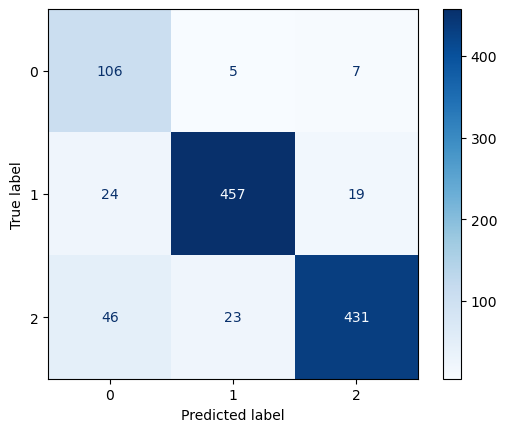

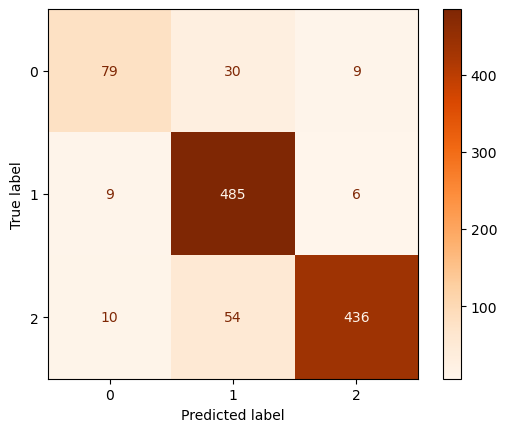

In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Evaluate models
print("Logistic Accuracy:", accuracy_score(bulba_dev_labels, y_predlog))
print("Bayesian Accuracy:", accuracy_score(bulba_dev_labels, y_predbay))

# Confusion matrices
cm_log = confusion_matrix(bulba_dev_labels, y_predlog)
cm_bay = confusion_matrix(bulba_dev_labels, y_predbay)

# Plot confusion matrices
ConfusionMatrixDisplay(cm_log).plot(cmap='Blues')
ConfusionMatrixDisplay(cm_bay).plot(cmap='Oranges')


In [ ]:
coef_log = logic_classifier.coef_.flatten()
largest_indices = np.argsort(coef_log)[-10:]
print(largest_indices)
#nb_classifier
coef_bay = nb_classifier.coef_.flatten()
largest_indices = np.argsort(coef_bay)[-10:]
print(largest_indices)

#compare indice letters
vectorizer = CountVectorizer(analyzer='char',ngram_range=(3,6))

X_unseen_counts = vectorizer.fit(wooki_train_text)

[ 845530  837513 1280261  352699  782462   81295 1116192  352698   73681
   81323]


AttributeError: 'MultinomialNB' object has no attribute 'coef_'

In [88]:
import numpy as np

# Top 10 indices from Logistic Regression
largest_log_indices = np.argsort(logic_classifier.coef_.flatten())[-100:][::-1]
#print(largest_log_indices)

# Top 10 indices from Naïve Bayes
largest_bay_indices2 = np.argsort(nb_classifier.feature_log_prob_.flatten())[-100:][::-1]
#print(largest_bay_indices2)

count=0
for number in largest_log_indices:
    if number in largest_bay_indices2:
        count+=1

count


15

## 15 of the same indecies in top 100